# Problem _A_PART_2_Ensamble

  Implemented Ensable by stacking base learners in three ways
  
    - Took best four performing model from part 1 and added some variation to it to create 10 base learner
    
    - Generating base learner model dynamically 

In [80]:
!nvidia-smi

Fri Apr 30 10:42:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.33       Driver Version: 461.33       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro T2000 wi... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8     1W /  N/A |   3019MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [81]:
import gc
import random
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers import Activation
from IPython.display import display
from keras.utils import plot_model
from keras.models import model_from_json

In [82]:
def set_seed():
  tf.random.set_seed(207241)
  np.random.seed(207241)
  random.seed(207241)

In [83]:
# Taken from Problem _A_PART_1
#Read data from hdf5 file(code provided with assignment)

def loadDataH5():        
    
    with h5py.File('./earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))        
    return trainX, trainY, valX, valY

#### Get All details about data
    - Training & Validation
    - Image Dimesnion 
    - Classes

In [84]:
# Taken from Problem _A_PART_1
#Get All details about data
def get_working_data():
    
  trainX, trainY, valX, valY = loadDataH5()
  training_data_count,height,width,depth = trainX.shape
  unique_val, class_dist = np.unique(trainY,return_counts=True)
  print("Number of classes:",unique_val.shape[0])
  print("Class Value:",unique_val)
  print("Class distribution:",class_dist)
  print(trainX.shape,trainY.shape)
  print(valX.shape,valY.shape)
  trainX = trainX.astype("float") / 255.0
  valX = valX.astype("float") / 255.0
    
  return trainX, trainY, valX, valY,(height,width,depth,unique_val.shape[0])

#Making training & validation data global


g_trainX,g_trainY,g_valX,g_valY,(g_height,g_width,g_depth,g_classes) = \
                        get_working_data()

Number of classes: 9
Class Value: [0 1 2 3 4 5 6 7 8]
Class distribution: [2400 2400 2400 2000 2000 1600 2000 2400 2000]
(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


# Class for storing perfomance of executed model

In [85]:
# Taken from Problem _A_PART_1
#Stores the performance matrix for each model 
class MODEL_PERFORMANCE:

  def __init__(self, val_loss,val_acc,train_loss,train_acc):
    self.val_loss = val_loss
    self.val_acc  = val_acc
    self.train_loss = train_loss
    self.train_acc = train_acc

# For each model, performance matrix is stored as key-value 
# pair, with key as model name
# Value is MODEL_PERFORMANCE object

class RECORD:

  # Initialise the dictionary
  def __init__(self):
    self.store = {}    
  
  # Add an entry to the dictionary
  def add_entry(self,name,performance):
    self.store[name] = performance


#This class is for storing predicted probability value that's output
# from each base learner
#used later for calculating ensemble output

class MODEL_PREDICTED_PROB:

  def __init__(self):
    self.store = {}
  
  # Store predicted value in dictionary with key as base learner name
  def add_prediction(self,name,value):
    self.store[name]=value



# Global object 

In [86]:
#

#Stores performances of base learners 

g_record_v1 = RECORD() # Stores performance of base learner from ensemble 1
g_record_v2 = RECORD() # Stores performance of base learner from ensemble 2




#Stores predicted probability value from each base learner
g_predicted_y_en1 = MODEL_PREDICTED_PROB()
g_predicted_y_en2 = MODEL_PREDICTED_PROB()

MODEL_NAME_PREFIX = "Base_learner_"


### Get Base Learner Performance

In [87]:
# From stored performance history, get the maximum training/validation accuracy,
# minimum training/validation loss
#
# NOTE: Maximum validation accuracy taken at the point where minimum validation loss occured 
#       and not the minimum value of val_acc in performance history
#

def get_base_learner_performance(store_obj):
    
  result = []
  for model in store_obj.store:  
    model_perf = store_obj.store[model]
    min_val_loss = min(model_perf.val_loss)
    
    #Maximum validation accuracy taken at point where validation loss was minimum
    max_val_acc = model_perf.val_acc[model_perf.val_loss.index(min_val_loss)]
    #Append collected value to the list
    result.append([model,max_val_acc,max(model_perf.train_acc),min_val_loss,min(model_perf.train_loss)])
  
  #Convert list to data frame
  df = pd.DataFrame(result, columns =['Model', 'Val Acc', 'Train Acc', 'Val Loss', 'Train Loss'], dtype = float)

  return df
  

#### Wrapper function for calling get_base_learner_performance

In [88]:
def get_base_learner_perfromance_ensamble1():
    return get_base_learner_performance(store_obj = g_record_v1)

In [89]:
def get_base_learner_perfromance_ensamble2():
    return get_base_learner_performance(store_obj = g_record_v2)


### Get Ensamble Prediction

In [90]:
# This function takes prediction(probability) value from all base learners
# Sum them and get the average probability value (sum/number of base learners)
# 
# The index having maximum of probabilty determine the predicted class
#
# Calculate the accuracy which will be accurcy of ensemble
#

def get_ensamble_prediction_score(predicted_y_store):
    
  pred = np.zeros([g_valY.shape[0],g_classes])
  for item in predicted_y_store.store:
    pred += predicted_y_store.store[item]
  
  pred = pred/len(predicted_y_store.store)
  predY = np.argmax(pred,axis=1)
  score = metrics.accuracy_score(predY,g_valY)
    
  return score

#### Wrapper function for calling get_ensamble_prediction_score

In [91]:
def get_ensamble1_prediction_score():
    return get_ensamble_prediction_score(predicted_y_store = g_predicted_y_en1)

In [92]:
def get_ensamble2_prediction_score():
    return get_ensamble_prediction_score(predicted_y_store = g_predicted_y_en2)

# PLOTS

-  Sigle plot produced at the end of execution of each model depicting validation/training loss/accuracy 

In [93]:
# Taken from Problem _A_PART_1
# Performance plot for a model depicting training/validation loss/accuracy
# Stores the performance matrix for later analysis

def plot_model_performance(name,history,model_history):
  plt.style.use("ggplot")
  plt.figure(figsize=(7,6))
                    
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

 
  #Print best score 
  print("\nModel Performance Summary:\n")
  
  
  min_val_loss = min(history.history["val_loss"])

  epoch_index = history.history["val_loss"].index(min_val_loss)
    
  best_val_accuracy = history.history["val_accuracy"][epoch_index]

  print("Min validation loss:",min_val_loss," at EPOCH:", epoch_index+1)

  print("\nValidation Accuracy: ",best_val_accuracy)
  
  #Store the above performance matrix
  model_history.add_entry(name,MODEL_PERFORMANCE( \
                             val_acc = history.history["val_accuracy"], \
                            val_loss = history.history["val_loss"], \
                            train_loss = history.history["loss"],
                            train_acc = history.history["accuracy"]))

In [94]:
#SNS Plot displaying details from passed dataframe

def plot_performnaces(data_frame):

  plt.figure()
  plot = sns.barplot(y='Model', x='Val Acc', data=data_frame)
  plot.set_title('Validation Accuracy (All)')
  plt.show()

#### Utility function for executing model

In [95]:
# Taken from Problem _A_PART_1
# This function used for building,compiling and testing the model
def call_model_from_by_name(model_name,model_history, \
                            input_data = (g_trainX,g_trainY, \
                                          g_valX,g_valY),\
               inputshape = (g_height,g_width,g_depth), \
               classes = g_classes, iterations = 40, optimizer_obj=None):
    
  NUM_EPOCHS = iterations
  trainX,trainY,valX,valY = input_data
  model = model_name(inputshape,classes)
 

  if optimizer_obj==None:
    optimizer_obj = keras.optimizers.SGD(learning_rate=0.01)

  model.compile(optimizer=optimizer_obj, loss='sparse_categorical_crossentropy', \
                metrics=['accuracy'])
  print(model.summary())
  #Plot Model
  plots = plot_model(model,show_shapes=True,expand_nested=True)
  display(plots)
  
  history = model.fit(trainX, trainY, epochs = NUM_EPOCHS,  validation_data= \
                    (valX, valY), callbacks = get_all_callback(model.name+".hdf5"))  
  
  plot_model_performance(model.name,history,model_history)  
  #Invoking garbage collection manually helps allivaiting the problem of 
  # high RAM usage in
  gc.collect()

In [96]:
def call_ensamble1_baselearner(baselearner_name):
    call_model_from_by_name(model_name = baselearner_name, model_history = g_record_v1)

# **Callbacks**


1.   Early Stopping on Minimum Validation Loss
2.   Checkpointing on Minimum Validation Loss
3.   Learning Rate Schedular

In [97]:
# Taken from Problem _A_PART_1
def get_early_stoping_cb_on_min_val_loss(patience_num = 3):
  return EarlyStopping(monitor='val_loss', mode='min', verbose=1, \
                       patience=patience_num)

def get_model_checkpoint_cb_on_min_val_loss(file_name):
  return ModelCheckpoint(file_name, monitor="val_loss", 	mode="min", \
                         save_best_only=True, verbose=1)	

def learning_rate_schedular_fun(epoch, lr):
  if epoch <10:
    return lr 
  else:
    return lr*tf.math.exp(-.1)
  
def get_model_learning_rate_cb():
  return tf.keras.callbacks.LearningRateScheduler(learning_rate_schedular_fun,\
                                                  verbose=1)


def get_basic_callback():
  return [get_early_stoping_cb_on_min_val_loss()]

def get_basic_and_lrs_callback():
  return [get_early_stoping_cb_on_min_val_loss(),get_model_learning_rate_cb()]

def get_all_callback(file_name):
  return [get_early_stoping_cb_on_min_val_loss(),\
          get_model_checkpoint_cb_on_min_val_loss(file_name),
          get_model_learning_rate_cb()]

# ENSAMBLE 1 IMPLEMENTATION

# **BASE LEARNERS**

In [98]:
#Base Learners
# Model_1,Model_2,Model_3,Model_4 are from Problem_A_PART_1
# Rest All are having variantion in their number of layers
# Filter size, activation function, dropout layers

BASE_ENSAMBLE_LEARNER_PREFIX = "EN_1_"

class ENSEMBLE_1:
    
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,Fully Connected Layer,Softmax Layer
    @staticmethod
    def Model_1(inputshape, classes):

      model = \
      keras.Sequential( name = BASE_ENSAMBLE_LEARNER_PREFIX+ "Model_1", layers= \
          [
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),   
            keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model
    
    
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,
    # Fully Connected Layer,Softmax Layer
    @staticmethod
    def Model_2(inputshape, classes):

      model = \
      keras.Sequential( name = BASE_ENSAMBLE_LEARNER_PREFIX+ "Model_2", layers= \
          [
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),   
            keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model
    
    
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (256,(3,3),"SAME"),MAXPOOLING,
    # Fully Connected Layer,Softmax Layer
    @staticmethod
    def Model_3(inputshape, classes):

      model = \
      keras.Sequential( name = BASE_ENSAMBLE_LEARNER_PREFIX+ "Model_3", layers= \
          [
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),   
            keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model
    
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (256,(3,3),"SAME"),MAXPOOLING,
    # dropout layer
    # Fully Connected Layer,Softmax Layer
    @staticmethod
    def Model_4(inputshape, classes):

      model = \
      keras.Sequential( name = BASE_ENSAMBLE_LEARNER_PREFIX+ "Model_4", layers= \
          [
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),   
            keras.layers.Dropout(0.2),
            keras.layers.Dense(512,activation='relu'),          
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model
    
        
    # 1 CONV (32,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,        
    # Fully Connected Layer,Softmax Layer
    @staticmethod
    def Model_5(inputshape, classes):
    
      model = \
      keras.Sequential( name = BASE_ENSAMBLE_LEARNER_PREFIX+ "Model_5", layers= \
          [
            tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model

    
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,    
    # 1 CONV (256,(3,3),"SAME"),MAXPOOLING,        
    # 2 Fully Connected Layer,Softmax Layer
    @staticmethod
    def Model_6(inputshape, classes):
    
      model = \
      keras.Sequential( name = BASE_ENSAMBLE_LEARNER_PREFIX+ "Model_6", layers= \
          [
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(1024,activation='relu'),
            keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model

    # 2 CONV (32,(3,3),"SAME"),MAXPOOLING,
    # 2 CONV (64,(3,3),"SAME"),MAXPOOLING,
    # 2 CONV (128,(3,3),"SAME"),MAXPOOLING,            
    # 2 Fully Connected Layer,Softmax Layer
    @staticmethod
    def Model_7(inputshape, classes):
    
      model = \
      keras.Sequential( name = BASE_ENSAMBLE_LEARNER_PREFIX+ "Model_7", layers= \
          [
            tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            tf.keras.layers.Conv2D (32, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model


    
    # 1 CONV (32,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (256,(3,3),"SAME"),MAXPOOLING,
    # 1 Fully Connected Layer,Softmax Layer
    @staticmethod
    def Model_8(inputshape, classes):
    
      model = \
      keras.Sequential( name = BASE_ENSAMBLE_LEARNER_PREFIX+ "Model_8", layers= \
          [
            tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model

    # 1 CONV (32,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (256,(3,3),"SAME"),MAXPOOLING,
    # 1 Fully Connected Layer,Softmax Layer
    @staticmethod
    def Model_9(inputshape, classes):
    
      model = \
      keras.Sequential( name = BASE_ENSAMBLE_LEARNER_PREFIX+ "Model_9", layers= \
          [
            tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(512,activation='relu'),
            keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model


    # 1 CONV (32,(3,3),"SAME"),MAXPOOLING,Dropout
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,Dropout
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,Dropout
    # 1 CONV (256,(3,3),"SAME"),MAXPOOLING,Dropout
    # Dropout 1 Fully Connected Layer,Dropout, Softmax Layer
    @staticmethod
    def Model_10(inputshape, classes):
    
      model = \
      keras.Sequential( name = BASE_ENSAMBLE_LEARNER_PREFIX+ "Model_10", layers= \
          [
            tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(512,activation='relu'),
            keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model 
   

### Load models from weight and make the prediction

In [99]:
def load_model_from_wt_and_predict(model,prediction_store_obj):
    
  model_obj = model((g_height,g_width,g_depth),g_classes)
  model_obj.load_weights(model_obj.name+".hdf5")
  optimizer_obj = keras.optimizers.SGD(learning_rate=0.01)
  model_obj.compile(optimizer=optimizer_obj, loss='sparse_categorical_crossentropy', \
                metrics=['accuracy'])
  predicted_value = model_obj.predict(g_valX)
  
  # Predicted value added to store for calculating ensamble accuracy
  prediction_store_obj.add_prediction(model_obj.name,predicted_value)

# EXECUTING THE ENSAMBLE

In [103]:
#List of base learners

BASE_LEARNERS = [ENSEMBLE_1.Model_1,ENSEMBLE_1.Model_2,ENSEMBLE_1.Model_3, \
                ENSEMBLE_1.Model_4,ENSEMBLE_1.Model_5,ENSEMBLE_1.Model_6, \
                ENSEMBLE_1.Model_7,ENSEMBLE_1.Model_8,ENSEMBLE_1.Model_9, \
                ENSEMBLE_1.Model_10]


# Steps are:
# 1. Create and train all the base learners and save its weight at point of min validation loss
# 2. Create the learner and load the trained weight from the weight file save in previous step
#    and do the prediction. Save the predicted probability for each base learner
# 3. Add the probability value obtained from each base leaners and divide the value with 
#    the number of base learner present in the ensamle to get ensamble validation score
# 4. Plot the collected perforamce matrix 
#

def run_base_ensamble():
    
  # Setting seed for reproduciability 
  set_seed()
  
  #Setp 1
  # Create and execute all the base learners  
  for learner in BASE_LEARNERS:
    #Call model and save weight at minimum validation loss point
    call_ensamble1_baselearner(learner)
  
  gc.collect()
  
  #Setp 2
  #Load the model from weight and do predict and save probability
  for learner in BASE_LEARNERS:
    #Call model and save weight for minimum val loss
    load_model_from_wt_and_predict(learner, g_predicted_y_en1)
  
  # At this point, validation accuracy of all the base learners are available
  df = get_base_learner_perfromance_ensamble1()
  
  print("\nBase Learner Performnace Summmary:\n")
  display(df)

  #Need Model & Val Accuracy column for comparision
  df_acc = df[['Model', 'Val Acc']]
  
  #Setp 3
  ensamble_val_acc = get_ensamble1_prediction_score()
  
  #Setp 4
  df_acc = df_acc.append({'Model':'Ensamble','Val Acc':ensamble_val_acc},ignore_index=True)


  display(df_acc)
  plot_performnaces(df_acc)


## RUN BASE ENSAMBLE

Model: "EN_1_Model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_62 (Dense)             (None, 512)               33554944  
_________________________________________________________________
dense_63 (Dense)             (None, 9)                 4617      
Total params: 33,561,353
Trainable params: 33,561,353
Non-trainable params: 0
_________________________________________________________________
None


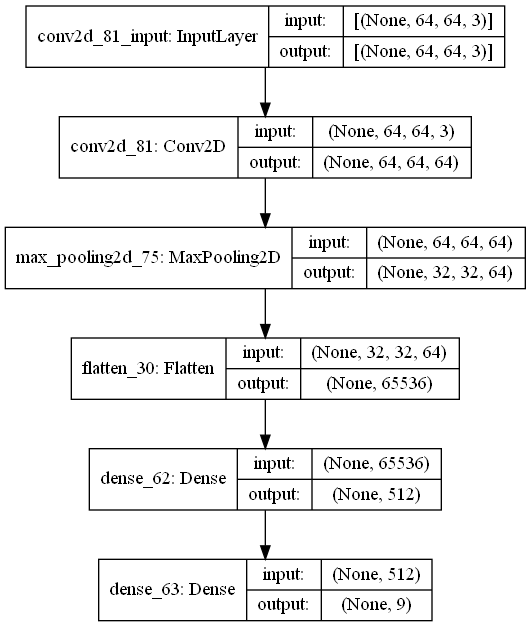

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 9s 14ms/step - loss: 1.8393 - accuracy: 0.3081 - val_loss: 1.5473 - val_accuracy: 0.3910

Epoch 00001: val_loss improved from inf to 1.54733, saving model to EN_1_Model_1.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 8s 14ms/step - loss: 1.4490 - accuracy: 0.4598 - val_loss: 1.4126 - val_accuracy: 0.4625

Epoch 00002: val_loss improved from 1.54733 to 1.41261, saving model to EN_1_Model_1.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 8s 14ms/step - loss: 1.3187 - accuracy: 0.5166 - val_loss: 1.1433 - val_accuracy: 0.5848

Epoch 00003: val_loss improved from 1.41261 to 1.14326, saving model to EN_1_Model_1.hdf5
Epoch 4/40

Epoch 00004: LearningRateScheduler red

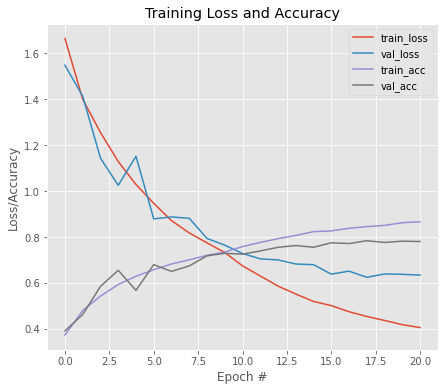


Model Performance Summary:

Min validation loss: 0.6244842410087585  at EPOCH: 18

Validation Accuracy:  0.7835416793823242
Model: "EN_1_Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)               167777

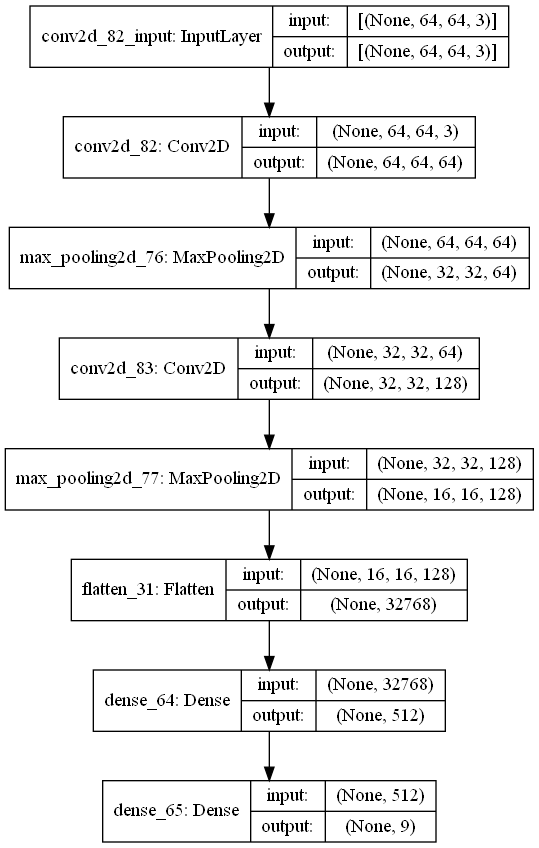

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 9s 15ms/step - loss: 1.8834 - accuracy: 0.2888 - val_loss: 1.5264 - val_accuracy: 0.4217

Epoch 00001: val_loss improved from inf to 1.52637, saving model to EN_1_Model_2.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 9s 15ms/step - loss: 1.4435 - accuracy: 0.4632 - val_loss: 1.3720 - val_accuracy: 0.4812

Epoch 00002: val_loss improved from 1.52637 to 1.37203, saving model to EN_1_Model_2.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 9s 15ms/step - loss: 1.2507 - accuracy: 0.5420 - val_loss: 1.0435 - val_accuracy: 0.6115

Epoch 00003: val_loss improved from 1.37203 to 1.04349, saving model to EN_1_Model_2.hdf5
Epoch 4/40

Epoch 00004: LearningRateScheduler red

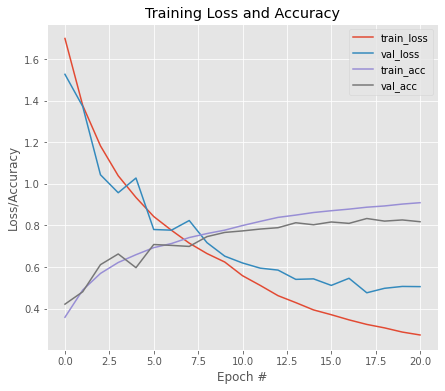


Model Performance Summary:

Min validation loss: 0.4763733446598053  at EPOCH: 18

Validation Accuracy:  0.8333333134651184
Model: "EN_1_Model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 8, 8, 256)         0     

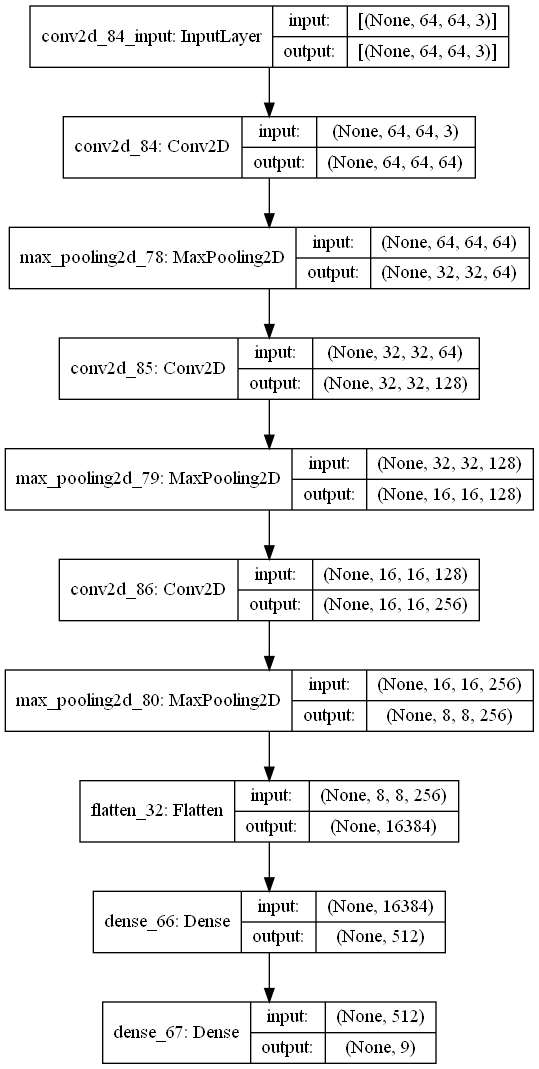

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 11s 18ms/step - loss: 1.9757 - accuracy: 0.2480 - val_loss: 1.5290 - val_accuracy: 0.4292

Epoch 00001: val_loss improved from inf to 1.52899, saving model to EN_1_Model_3.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 11s 18ms/step - loss: 1.4507 - accuracy: 0.4569 - val_loss: 1.5143 - val_accuracy: 0.4240

Epoch 00002: val_loss improved from 1.52899 to 1.51428, saving model to EN_1_Model_3.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 11s 18ms/step - loss: 1.2879 - accuracy: 0.5285 - val_loss: 1.1128 - val_accuracy: 0.5756

Epoch 00003: val_loss improved from 1.51428 to 1.11282, saving model to EN_1_Model_3.hdf5
Epoch 4/40

Epoch 00004: LearningRateScheduler 

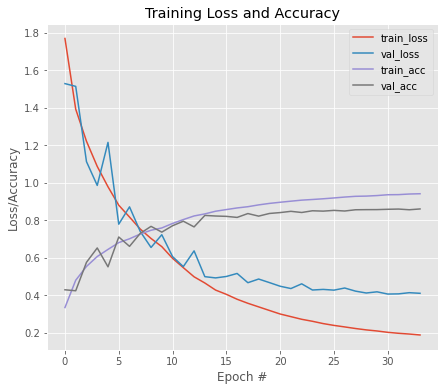


Model Performance Summary:

Min validation loss: 0.40639761090278625  at EPOCH: 31

Validation Accuracy:  0.8585416674613953
Model: "EN_1_Model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 8, 8, 256)         0    

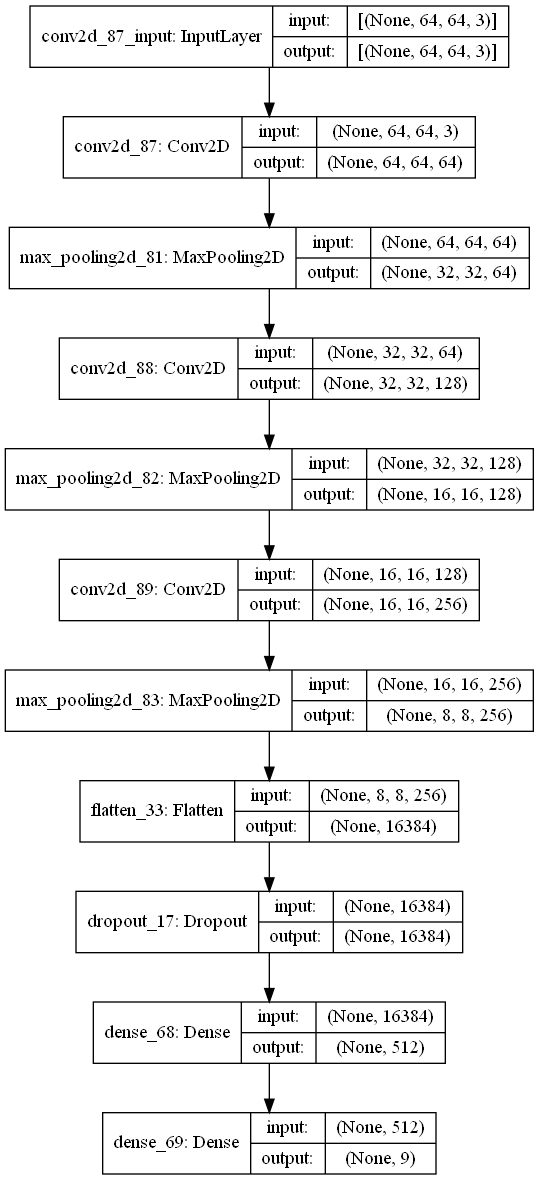

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 11s 18ms/step - loss: 1.9545 - accuracy: 0.2598 - val_loss: 1.4872 - val_accuracy: 0.4529

Epoch 00001: val_loss improved from inf to 1.48720, saving model to EN_1_Model_4.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 11s 18ms/step - loss: 1.4454 - accuracy: 0.4618 - val_loss: 1.4127 - val_accuracy: 0.4646s: 1.4468 - accuracy

Epoch 00002: val_loss improved from 1.48720 to 1.41269, saving model to EN_1_Model_4.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 11s 18ms/step - loss: 1.2715 - accuracy: 0.5373 - val_loss: 1.0834 - val_accuracy: 0.5915

Epoch 00003: val_loss improved from 1.41269 to 1.08341, saving model to EN_1_Model_4.hdf5
Epoch 4/40

Epoch 00004: Le

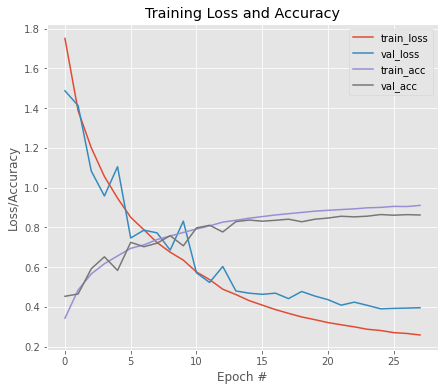


Model Performance Summary:

Min validation loss: 0.39006608724594116  at EPOCH: 25

Validation Accuracy:  0.8643749952316284
Model: "EN_1_Model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 8, 8, 128)         0    

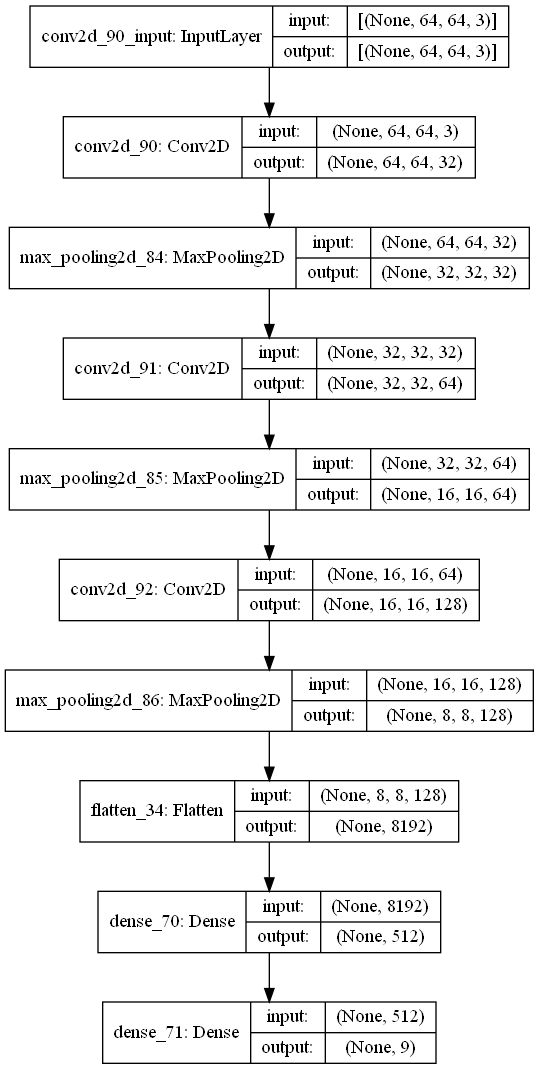

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 10ms/step - loss: 1.9577 - accuracy: 0.2510 - val_loss: 1.5383 - val_accuracy: 0.4169

Epoch 00001: val_loss improved from inf to 1.53831, saving model to EN_1_Model_5.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 9ms/step - loss: 1.4682 - accuracy: 0.4523 - val_loss: 1.4453 - val_accuracy: 0.4498706 - accuracy

Epoch 00002: val_loss improved from 1.53831 to 1.44533, saving model to EN_1_Model_5.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 9ms/step - loss: 1.2927 - accuracy: 0.5281 - val_loss: 1.1396 - val_accuracy: 0.5706

Epoch 00003: val_loss improved from 1.44533 to 1.13959, saving model to EN_1_Model_5.hdf5
Epoch 4/40

Epoch 00004: LearningRateS

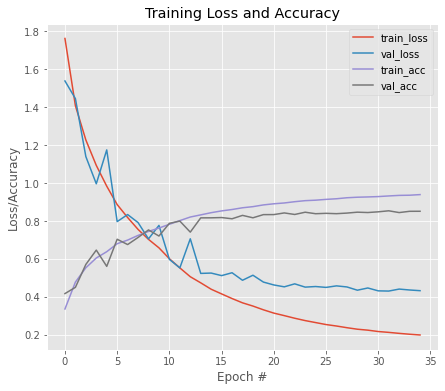


Model Performance Summary:

Min validation loss: 0.43015316128730774  at EPOCH: 32

Validation Accuracy:  0.8535416722297668
Model: "EN_1_Model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 8, 8, 256)         0    

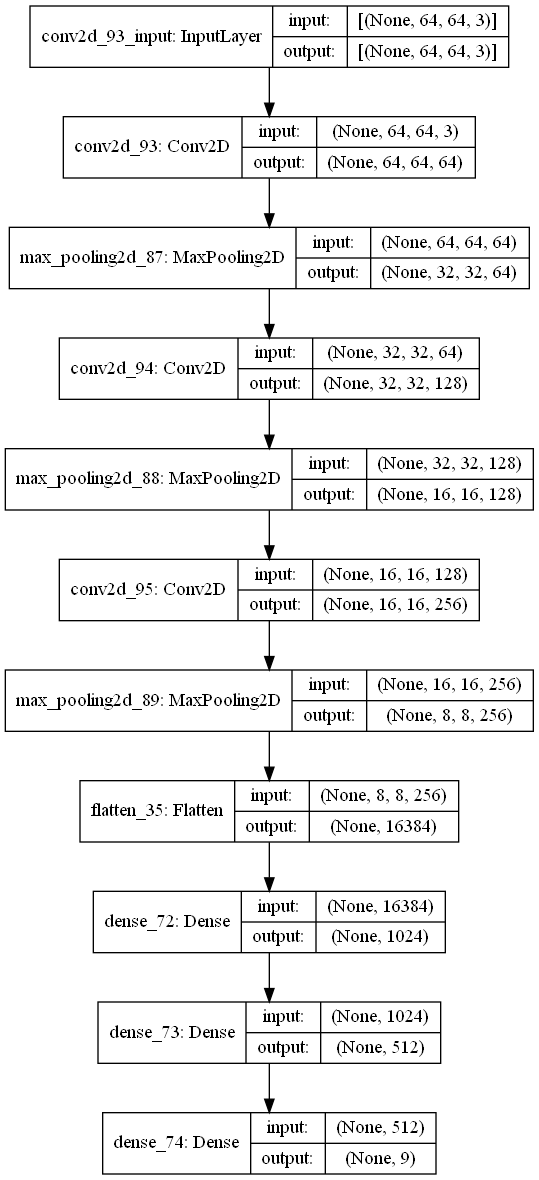

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 12s 20ms/step - loss: 1.9876 - accuracy: 0.2457 - val_loss: 1.5563 - val_accuracy: 0.4148

Epoch 00001: val_loss improved from inf to 1.55629, saving model to EN_1_Model_6.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 12s 19ms/step - loss: 1.4756 - accuracy: 0.4460 - val_loss: 1.5099 - val_accuracy: 0.4319

Epoch 00002: val_loss improved from 1.55629 to 1.50986, saving model to EN_1_Model_6.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 12s 19ms/step - loss: 1.2895 - accuracy: 0.5243 - val_loss: 1.0963 - val_accuracy: 0.5938

Epoch 00003: val_loss improved from 1.50986 to 1.09628, saving model to EN_1_Model_6.hdf5
Epoch 4/40

Epoch 00004: LearningRateScheduler 

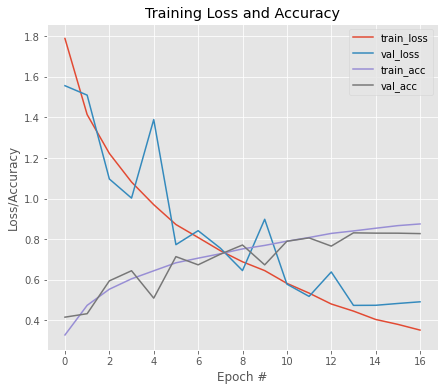


Model Performance Summary:

Min validation loss: 0.47288885712623596  at EPOCH: 14

Validation Accuracy:  0.8306249976158142
Model: "EN_1_Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 16, 16, 64)        0    

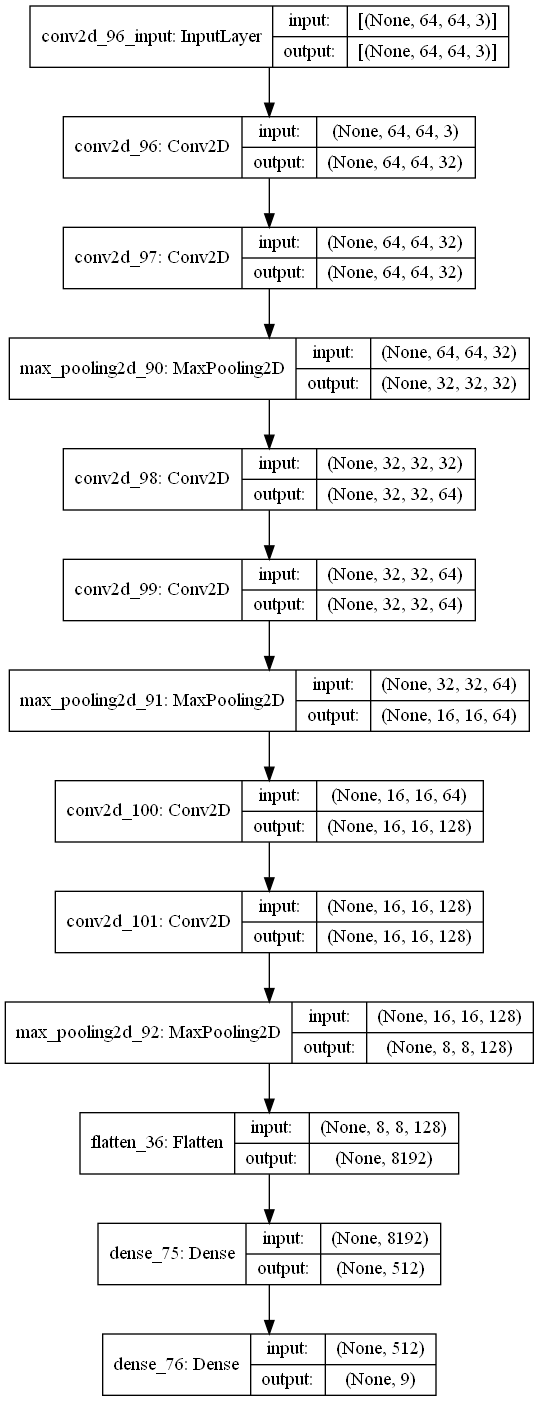

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 12s 19ms/step - loss: 2.0221 - accuracy: 0.2168 - val_loss: 1.6696 - val_accuracy: 0.3610

Epoch 00001: val_loss improved from inf to 1.66961, saving model to EN_1_Model_7.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 11s 19ms/step - loss: 1.5567 - accuracy: 0.4145 - val_loss: 1.6546 - val_accuracy: 0.3946

Epoch 00002: val_loss improved from 1.66961 to 1.65464, saving model to EN_1_Model_7.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 11s 19ms/step - loss: 1.3452 - accuracy: 0.5108 - val_loss: 1.1160 - val_accuracy: 0.5962

Epoch 00003: val_loss improved from 1.65464 to 1.11597, saving model to EN_1_Model_7.hdf5
Epoch 4/40

Epoch 00004: LearningRateScheduler 

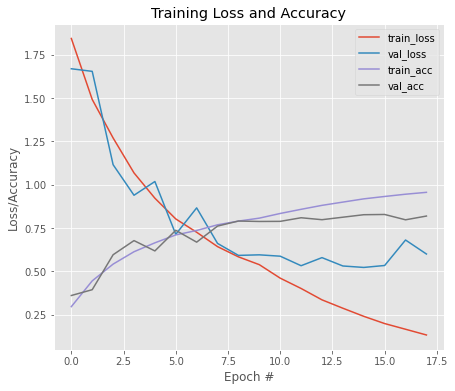


Model Performance Summary:

Min validation loss: 0.5230589509010315  at EPOCH: 15

Validation Accuracy:  0.8272916674613953
Model: "EN_1_Model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 8, 8, 128)         0     

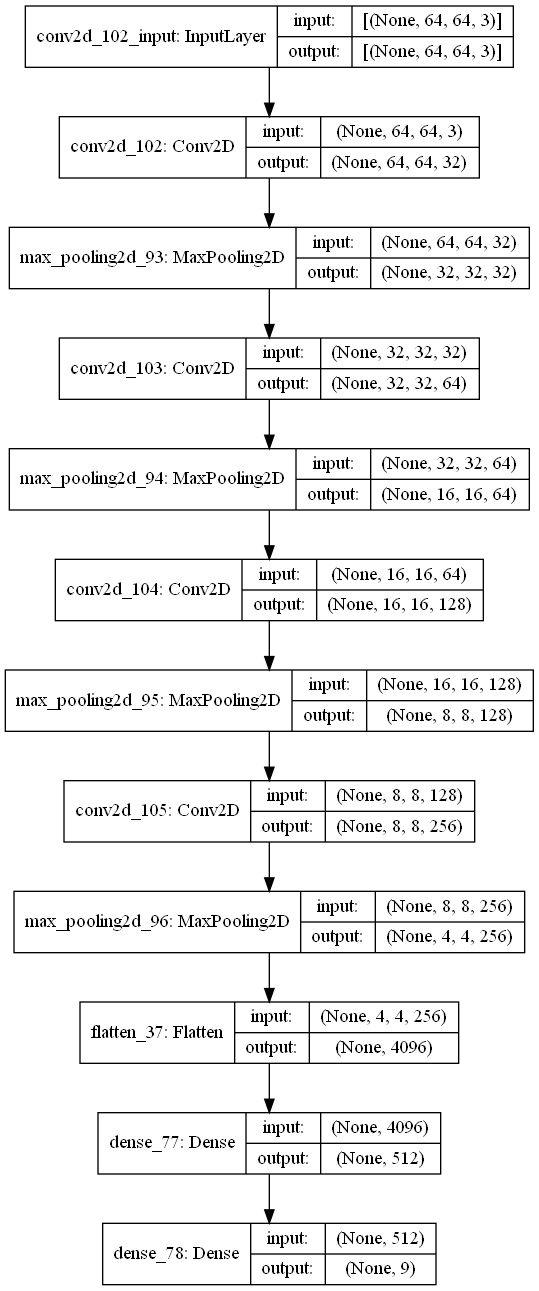

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 7s 11ms/step - loss: 2.0667 - accuracy: 0.2103 - val_loss: 1.5985 - val_accuracy: 0.3602

Epoch 00001: val_loss improved from inf to 1.59852, saving model to EN_1_Model_8.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 10ms/step - loss: 1.5281 - accuracy: 0.4225 - val_loss: 1.5628 - val_accuracy: 0.3946

Epoch 00002: val_loss improved from 1.59852 to 1.56281, saving model to EN_1_Model_8.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 10ms/step - loss: 1.3289 - accuracy: 0.5137 - val_loss: 1.1541 - val_accuracy: 0.5721

Epoch 00003: val_loss improved from 1.56281 to 1.15408, saving model to EN_1_Model_8.hdf5
Epoch 4/40

Epoch 00004: LearningRateScheduler red

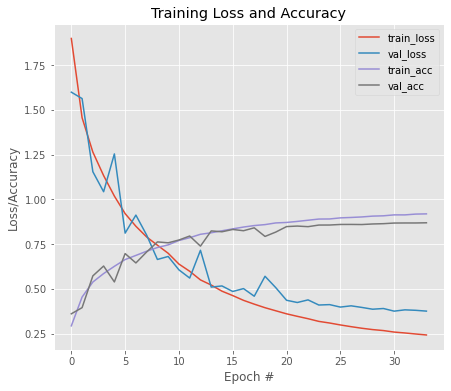


Model Performance Summary:

Min validation loss: 0.3750240206718445  at EPOCH: 31

Validation Accuracy:  0.8672916889190674
Model: "EN_1_Model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 8, 8, 128)         0     

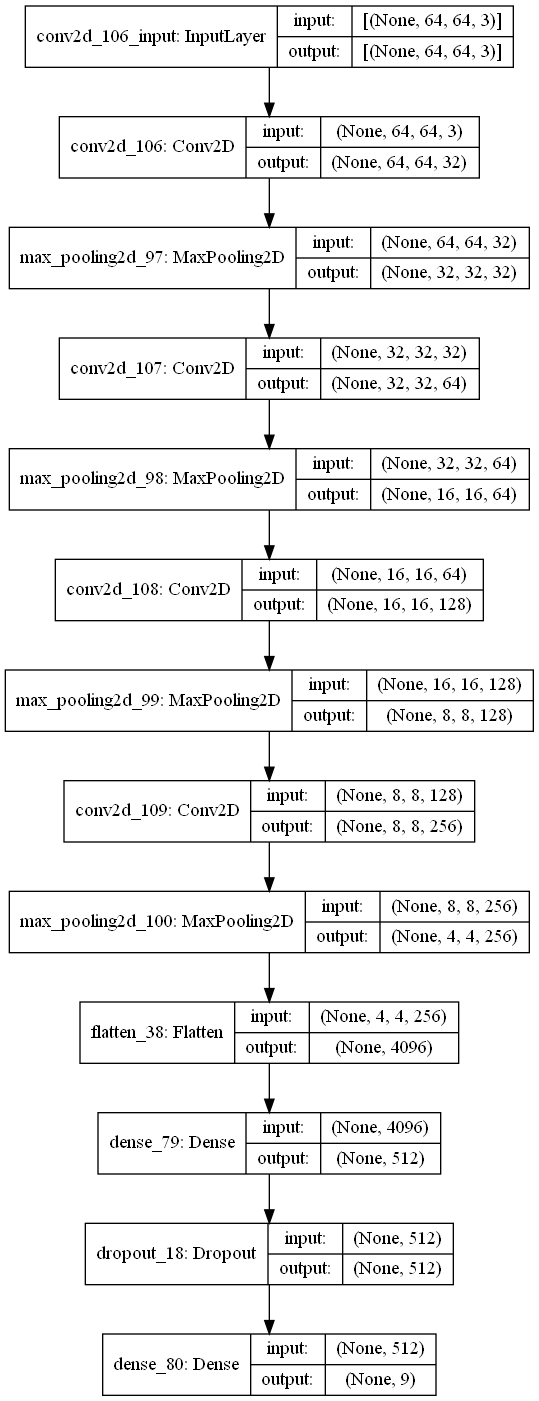

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 7s 11ms/step - loss: 2.0412 - accuracy: 0.2164 - val_loss: 1.5933 - val_accuracy: 0.3517

Epoch 00001: val_loss improved from inf to 1.59327, saving model to EN_1_Model_9.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 10ms/step - loss: 1.5510 - accuracy: 0.4122 - val_loss: 1.5262 - val_accuracy: 0.4183

Epoch 00002: val_loss improved from 1.59327 to 1.52625, saving model to EN_1_Model_9.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 10ms/step - loss: 1.3533 - accuracy: 0.5039 - val_loss: 1.1969 - val_accuracy: 0.5590

Epoch 00003: val_loss improved from 1.52625 to 1.19686, saving model to EN_1_Model_9.hdf5
Epoch 4/40

Epoch 00004: LearningRateScheduler red

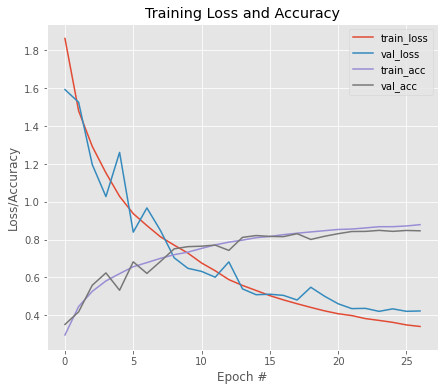


Model Performance Summary:

Min validation loss: 0.4209289848804474  at EPOCH: 24

Validation Accuracy:  0.8489583134651184
Model: "EN_1_Model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 16, 16, 64)        0    

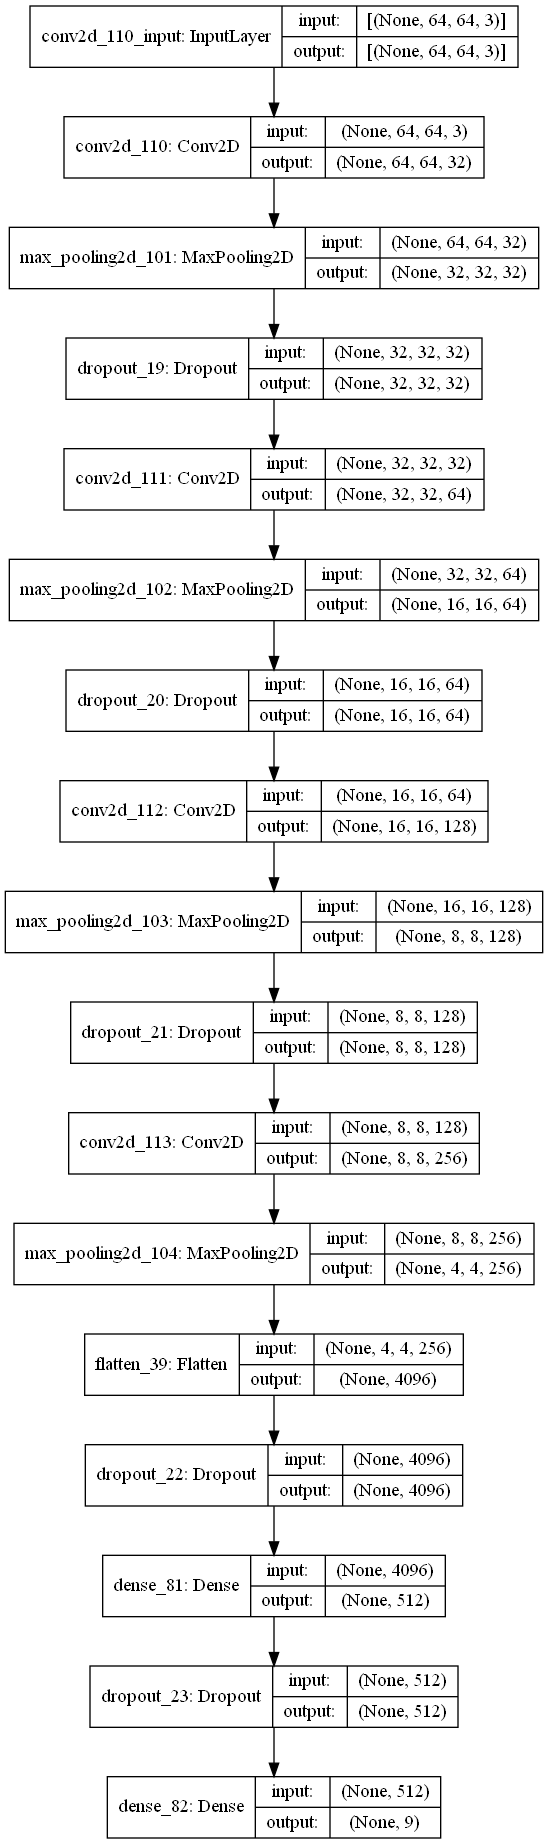

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 8s 12ms/step - loss: 2.0493 - accuracy: 0.2081 - val_loss: 1.7184 - val_accuracy: 0.3873

Epoch 00001: val_loss improved from inf to 1.71836, saving model to EN_1_Model_10.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 7s 11ms/step - loss: 1.5803 - accuracy: 0.3999 - val_loss: 1.7997 - val_accuracy: 0.2690

Epoch 00002: val_loss did not improve from 1.71836
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 7s 11ms/step - loss: 1.4426 - accuracy: 0.4710 - val_loss: 1.2390 - val_accuracy: 0.5256

Epoch 00003: val_loss improved from 1.71836 to 1.23898, saving model to EN_1_Model_10.hdf5
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776

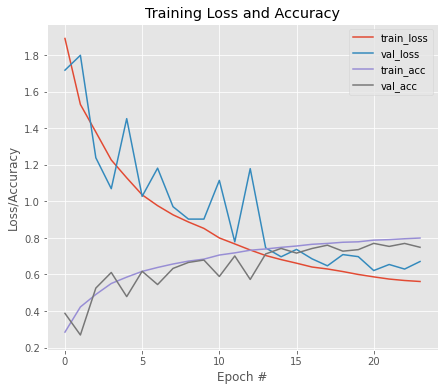


Model Performance Summary:

Min validation loss: 0.6215887665748596  at EPOCH: 21

Validation Accuracy:  0.7704166769981384

Base Learner Performnace Summmary:



,Model,Val Acc,Train Acc,Val Loss,Train Loss
0,EN_1_Model_1,0.783542,0.865990,0.624484,0.405549
1,EN_1_Model_2,0.833333,0.909323,0.476373,0.273604
2,EN_1_Model_3,0.858542,0.941510,0.406398,0.188090
3,EN_1_Model_4,0.864375,0.910521,0.390066,0.258262
4,EN_1_Model_5,0.853542,0.938958,0.430153,0.198569
5,EN_1_Model_6,0.830625,0.874531,0.472889,0.351043
6,EN_1_Model_7,0.827292,0.956458,0.523059,0.133271
7,EN_1_Model_8,0.867292,0.918542,0.375024,0.241890
8,EN_1_Model_9,0.848958,0.879219,0.420929,0.341015
9,EN_1_Model_10,0.770417,0.799635,0.621589,0.561698


,Model,Val Acc
0,EN_1_Model_1,0.783542
1,EN_1_Model_2,0.833333
2,EN_1_Model_3,0.858542
3,EN_1_Model_4,0.864375
4,EN_1_Model_5,0.853542
5,EN_1_Model_6,0.830625
6,EN_1_Model_7,0.827292
7,EN_1_Model_8,0.867292
8,EN_1_Model_9,0.848958
9,EN_1_Model_10,0.770417


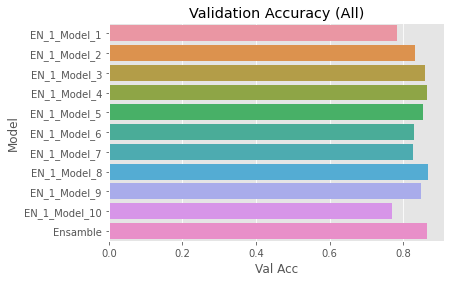

In [104]:
 run_base_ensamble()

# EANSEMBLE: APPROACH 2 
 - Generating Baselearners dynamically

# BASE LEARNER GENERATOR

In [40]:
# Generates base learner layers dynamically
# Generated model will have different number of layers
# Padding value choosen from ['same','valid']
# Activation function choosen from ["relu","tanh","selu","elu"]
# All model will have fixed filter kernel size 3,3
# Model will have dense layer count in [0,1,2]

BASE_LEARNER_COUNT = 10
def base_learner_generator(inputShape = (g_height,g_width,g_depth),classes=g_classes):
    
  padding_list = ['same','valid']
  activation_fun = ["relu","tanh","selu","elu"]
  kernel_size_list = [(3,3)]
  filter_count_list = [64,128,256,512]
  dense_layer_count = [0,1,2]
  consecutive_conv_layer_count = [0,1]
  selection = [True,False]
  set_seed()
  
  base_learner_list = []

  for model_number in range(0, BASE_LEARNER_COUNT):

    padding_type = random.choice(padding_list) # Padding 
    act_fun = random.choice(activation_fun)  # Activation function
    kernel = random.choice(kernel_size_list) # Kernel size
    dense_count = random.choice(dense_layer_count) # Number of dense layer to be added
    
    model = keras.Sequential(name=MODEL_NAME_PREFIX+str(model_number))
    model.add(tf.keras.layers.Conv2D (32, kernel, padding=padding_type, \
                                input_shape=inputShape, activation=act_fun))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    for item in filter_count_list:

      con_layer_count = random.choice(consecutive_conv_layer_count)
    
      # Model will have either 0 or one CONV layer with number of filters = in [64,128,256,512]
      # Couldnt stablise the model with more than 1 conv layer (consecutively)
    
    if con_layer_count>0:

        for con in range(0,con_layer_count):
          model.add(tf.keras.layers.Conv2D (item, kernel, padding=padding_type, activation=act_fun))
    
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        # Adding dropout at this stage is random
        if random.choice(selection) == True:
          model.add(keras.layers.Dropout(0.2))
      
    model.add(tf.keras.layers.Flatten())
    if dense_count>0:
      neuron_count = 512
      # If dense_count is more than one, number of neurons in the layer will be halfed
      for it in range(0,dense_count):
        model.add(keras.layers.Dense(neuron_count,activation=act_fun))
        if random.choice(selection) == True:
          model.add(keras.layers.Dropout(0.2))
        neuron_count = neuron_count/2

    model.add(tf.keras.layers.Dense(classes, activation='softmax'))
    
    base_learner_list.append(model)

  return base_learner_list

#### Wrapper function for calling the model

In [41]:
# This function used for building,compiling and testing the model
def call_model_from_object(model_obj, model_history, \
                           input_data = (g_trainX,g_trainY, \
                                         g_valX,g_valY),\
               iterations = 40, optimizer_obj=None):
    
  NUM_EPOCHS = iterations
  trainX,trainY,valX,valY = input_data
  model = model_obj
  
  if optimizer_obj==None:
    optimizer_obj = keras.optimizers.SGD(learning_rate = 0.01)

  model.compile(optimizer=optimizer_obj, loss='sparse_categorical_crossentropy', \
                metrics=['accuracy'])

  print(model.summary())

  #Plot Model
  plots = plot_model(model,show_shapes=True,expand_nested=True)
  display(plots)

  model_json = model.to_json()
  with open(model.name+".json", "w") as json_file:
    json_file.write(model_json)
  
  history = model.fit(trainX, trainY, epochs = NUM_EPOCHS,  validation_data= \
                    (valX, valY), callbacks = get_all_callback(model.name+".hdf5"))  
  
  plot_model_performance(model.name,history,model_history)  
  #Invoking garbage collection manually helps allivaiting the problem of 
  # high RAM usage in
  gc.collect()

In [42]:
def call_ensamble2_model(modelobj):
    call_model_from_object(model_obj = modelobj, model_history = g_record_v2)

##### Build Ensemble network 

In [43]:
def build_dynamic_ensemble():
  base_learner_list = base_learner_generator()
  for base_learner in base_learner_list:
    call_ensamble2_model(base_learner)

##### Load Saved model from JSON file, load weight, compile the mode and get predicted value

In [44]:
# Steps:
# Read model details from saved file on disk
# Create model object from the saved file
# Load trained weight of the model saved on disk
# Compile the model and get the predition(probability) on validation data
# Save the output to store for calulating ensemble output later

def load_model_from_file_and_predict(model_file_name,prediction_store_obj):

  model_file = open(model_file_name, 'r')
  retrieved_model_from_disk = model_file.read()
  model_file.close()

  loaded_model_obj = model_from_json(retrieved_model_from_disk)

  # Load trained weight 
  loaded_model_obj.load_weights(loaded_model_obj.name+".hdf5")
    
  # Compile the model
  optimizer_obj = keras.optimizers.SGD(learning_rate = 0.01)
  loaded_model_obj.compile(optimizer=optimizer_obj, loss='sparse_categorical_crossentropy', \
                metrics=['accuracy'])
  
  # Get predicted value and save it 
  predicted_value = loaded_model_obj.predict(g_valX)
  prediction_store_obj.add_prediction(loaded_model_obj.name,predicted_value)

#### Wrapper function for calling load_model_from_file_and_predict

In [45]:
def load_model_from_file_and_predict_ensamble2(model_file_name):
    load_model_from_file_and_predict(model_file_name,g_predicted_y_en2)

#### Wrapper function which build and execute the ensemble 

In [46]:
def run_dynamic_ensamble(MODEL_COUNT = BASE_LEARNER_COUNT):
    
  # Load model from file and get predicted value for all base learners  
  for item in range(0,MODEL_COUNT):
    load_model_from_file_and_predict_ensamble2(MODEL_NAME_PREFIX+str(item)+".json")
  
  # Combine the predicted value  obtained for all base learner 
  # and get ensemble prediction score
  df = get_base_learner_perfromance_ensamble2()
 
  print("Base Learner Performnace Summmary:")
  display(df)

  #Need Model & Val Accuracy column for comparision
  df_acc = df[['Model', 'Val Acc']]  
  ensamble_val_acc = get_ensamble2_prediction_score()

  df_acc = df_acc.append({'Model':'Ensamble','Val Acc':ensamble_val_acc},ignore_index=True)
  
  display(df_acc)
  plot_performnaces(df_acc)

Model: "Base_learner_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 512)       147968    
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 16, 16, 512)       0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               67109376  
_________________________________________________________________
dense_43 (Dense)             (None, 9)              

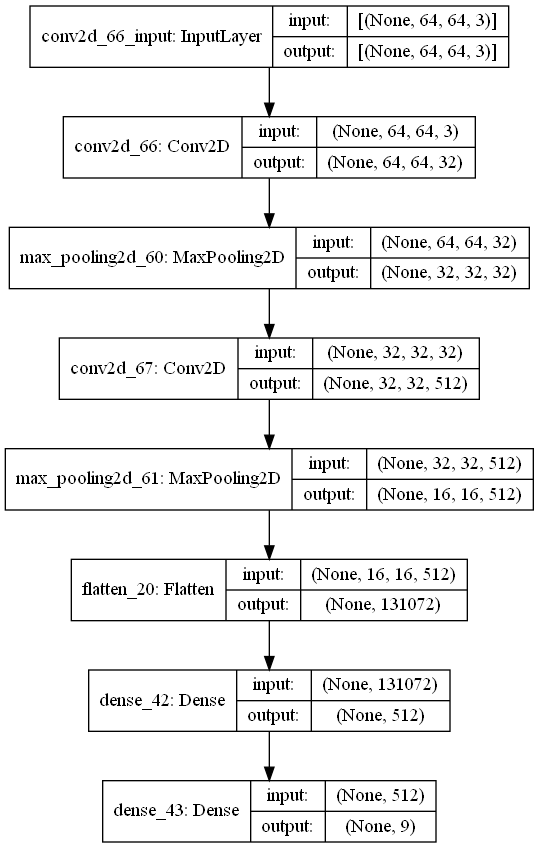

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 24s 38ms/step - loss: 1.6113 - accuracy: 0.4188 - val_loss: 1.3343 - val_accuracy: 0.5258

Epoch 00001: val_loss improved from inf to 1.33433, saving model to Base_learner_0.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 23s 38ms/step - loss: 1.0978 - accuracy: 0.6074 - val_loss: 1.0815 - val_accuracy: 0.5896

Epoch 00002: val_loss improved from 1.33433 to 1.08153, saving model to Base_learner_0.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 23s 38ms/step - loss: 0.9679 - accuracy: 0.6483 - val_loss: 0.9785 - val_accuracy: 0.6279

Epoch 00003: val_loss improved from 1.08153 to 0.97853, saving model to Base_learner_0.hdf5
Epoch 4/40

Epoch 00004: LearningRateSche

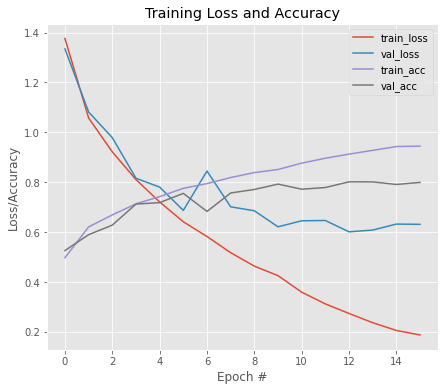


Model Performance Summary:

Min validation loss: 0.6009678840637207  at EPOCH: 13

Validation Accuracy:  0.8014583587646484
Model: "Base_learner_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               16777728  
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 256)               1313

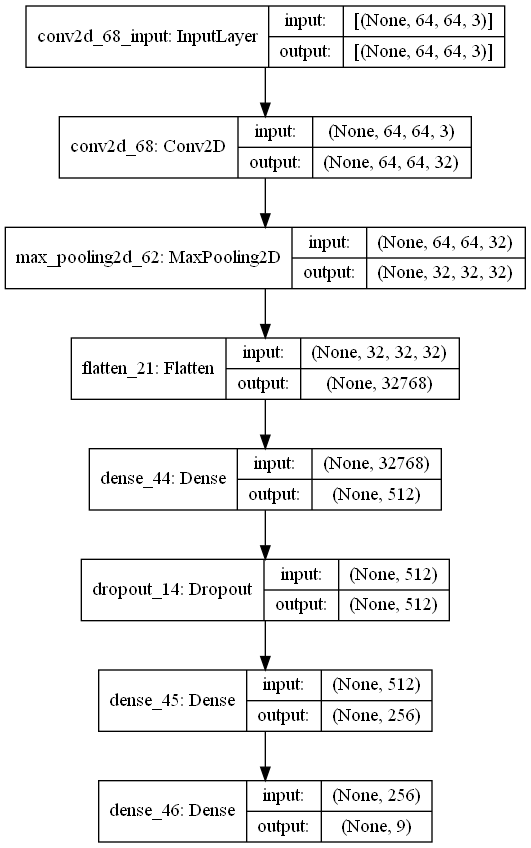

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 10ms/step - loss: 1.7505 - accuracy: 0.3491 - val_loss: 1.4285 - val_accuracy: 0.4485

Epoch 00001: val_loss improved from inf to 1.42855, saving model to Base_learner_1.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 10ms/step - loss: 1.3993 - accuracy: 0.4807 - val_loss: 1.4008 - val_accuracy: 0.4485 2s - loss: 1.4205 - accuracy - ETA: 2s - loss: 1.4 - ETA: 1s - l

Epoch 00002: val_loss improved from 1.42855 to 1.40083, saving model to Base_learner_1.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 10ms/step - loss: 1.2935 - accuracy: 0.5190 - val_loss: 1.2399 - val_accuracy: 0.5333A: 3s - los

Epoch 00003: val_loss improved from 1.40083 to 1.23986, savi

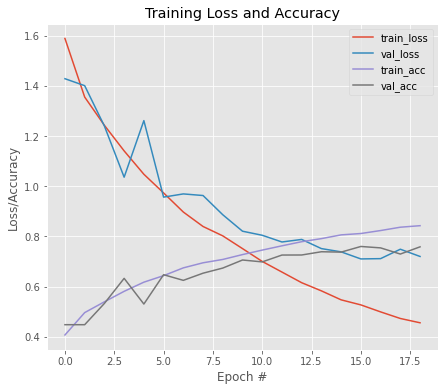


Model Performance Summary:

Min validation loss: 0.7105713486671448  at EPOCH: 16

Validation Accuracy:  0.7602083086967468
Model: "Base_learner_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 29, 29, 512)       147968    
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 14, 14, 512)       0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               5138

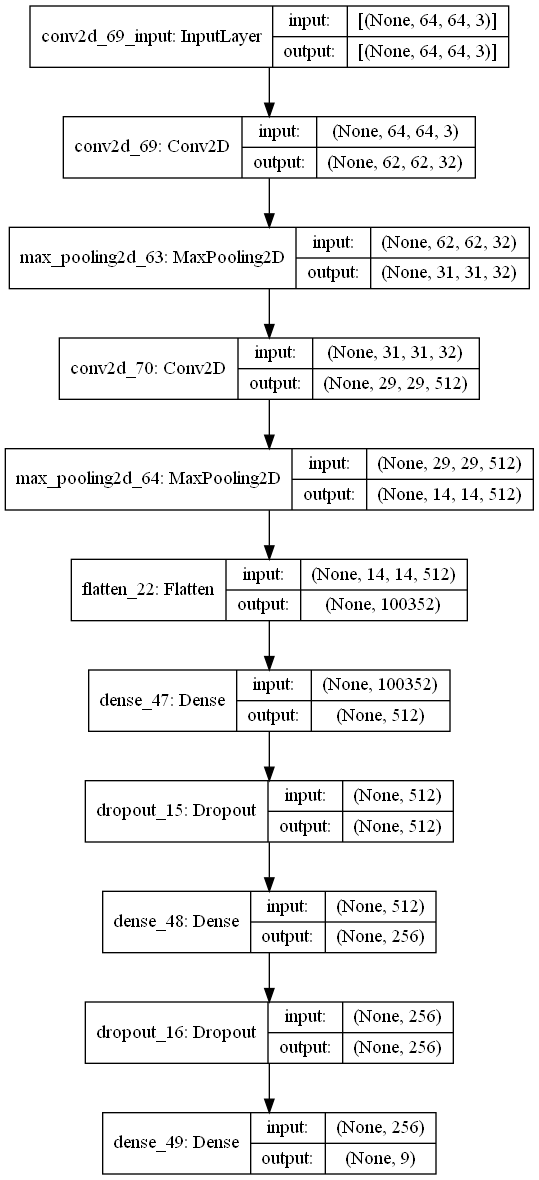

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 21s 33ms/step - loss: 1.6836 - accuracy: 0.3936 - val_loss: 1.3207 - val_accuracy: 0.5302

Epoch 00001: val_loss improved from inf to 1.32074, saving model to Base_learner_2.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 20s 33ms/step - loss: 1.2048 - accuracy: 0.5599 - val_loss: 1.2871 - val_accuracy: 0.5196

Epoch 00002: val_loss improved from 1.32074 to 1.28706, saving model to Base_learner_2.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 20s 33ms/step - loss: 1.0687 - accuracy: 0.6109 - val_loss: 0.9572 - val_accuracy: 0.6427

Epoch 00003: val_loss improved from 1.28706 to 0.95723, saving model to Base_learner_2.hdf5
Epoch 4/40

Epoch 00004: LearningRateSche

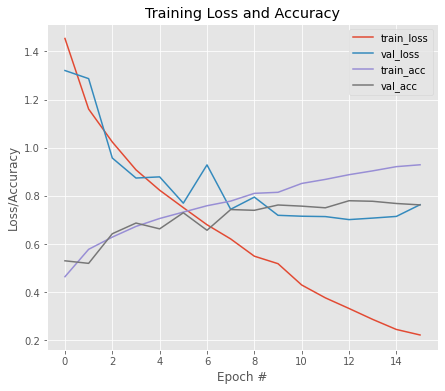


Model Performance Summary:

Min validation loss: 0.7014023661613464  at EPOCH: 13

Validation Accuracy:  0.7797916531562805
Model: "Base_learner_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 9)                 294921    
Total params: 295,817
Trainable params: 295,817
Non-trainable params: 0
_________________________________________________________________
None


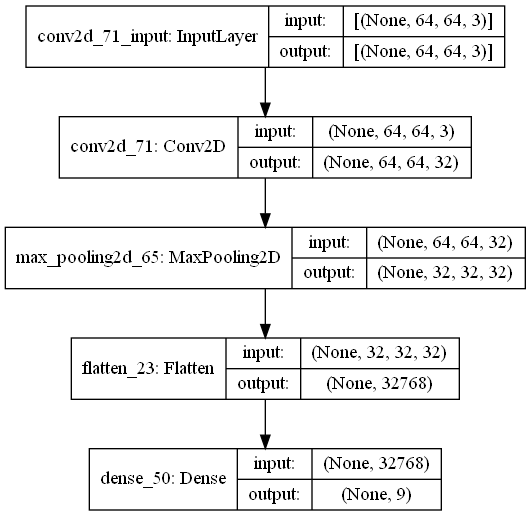

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 6ms/step - loss: 1.7438 - accuracy: 0.3506 - val_loss: 1.4395 - val_accuracy: 0.4621

Epoch 00001: val_loss improved from inf to 1.43953, saving model to Base_learner_3.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.4108 - accuracy: 0.4828 - val_loss: 1.3275 - val_accuracy: 0.4967

Epoch 00002: val_loss improved from 1.43953 to 1.32748, saving model to Base_learner_3.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.3358 - accuracy: 0.5111 - val_loss: 1.2620 - val_accuracy: 0.5302

Epoch 00003: val_loss improved from 1.32748 to 1.26196, saving model to Base_learner_3.hdf5
Epoch 4/40

Epoch 00004: LearningRateScheduler 

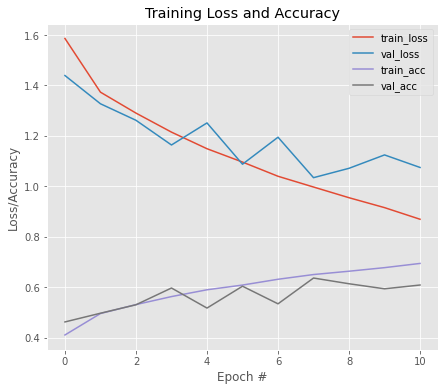


Model Performance Summary:

Min validation loss: 1.034360647201538  at EPOCH: 8

Validation Accuracy:  0.6362500190734863
Model: "Base_learner_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 9)                 294921    
Total params: 295,817
Trainable params: 295,817
Non-trainable params: 0
_________________________________________________________________
None


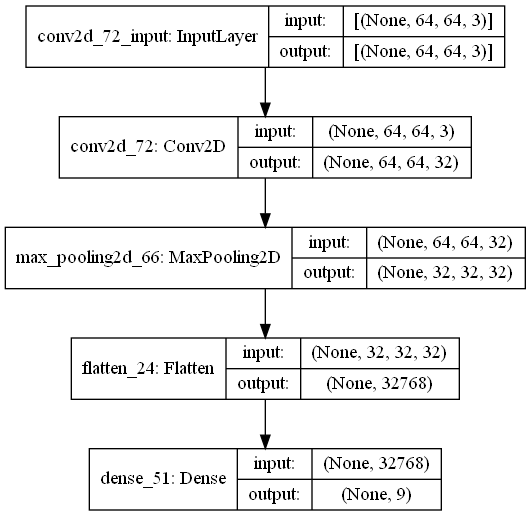

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.8538 - accuracy: 0.3060 - val_loss: 1.4937 - val_accuracy: 0.4260

Epoch 00001: val_loss improved from inf to 1.49367, saving model to Base_learner_4.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.4504 - accuracy: 0.4655 - val_loss: 1.3837 - val_accuracy: 0.4719

Epoch 00002: val_loss improved from 1.49367 to 1.38368, saving model to Base_learner_4.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.2960 - accuracy: 0.5270 - val_loss: 1.1648 - val_accuracy: 0.5638

Epoch 00003: val_loss improved from 1.38368 to 1.16475, saving model to Base_learner_4.hdf5
Epoch 4/40

Epoch 00004: LearningRateScheduler 

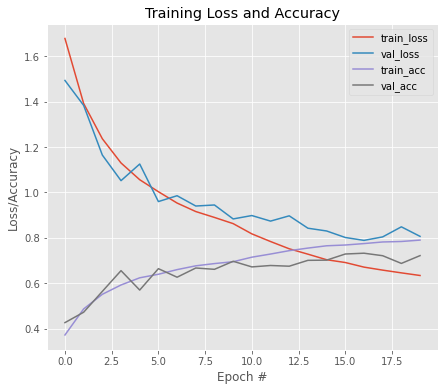


Model Performance Summary:

Min validation loss: 0.7885966300964355  at EPOCH: 17

Validation Accuracy:  0.7320833206176758
Model: "Base_learner_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 32, 32, 512)       147968    
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 16, 16, 512)       0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_52 (Dense)             (None, 512)               6710

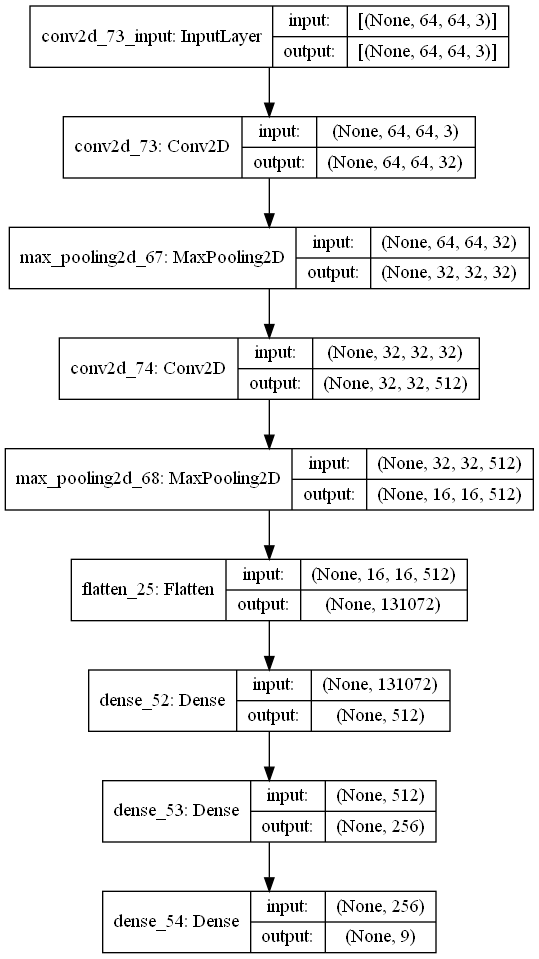

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 23s 38ms/step - loss: 1.7025 - accuracy: 0.3582 - val_loss: 1.2947 - val_accuracy: 0.5102

Epoch 00001: val_loss improved from inf to 1.29468, saving model to Base_learner_5.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 23s 38ms/step - loss: 1.2385 - accuracy: 0.5400 - val_loss: 1.1843 - val_accuracy: 0.5379

Epoch 00002: val_loss improved from 1.29468 to 1.18435, saving model to Base_learner_5.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 23s 38ms/step - loss: 1.1052 - accuracy: 0.5811 - val_loss: 1.0044 - val_accuracy: 0.6225

Epoch 00003: val_loss improved from 1.18435 to 1.00441, saving model to Base_learner_5.hdf5
Epoch 4/40

Epoch 00004: LearningRateSche

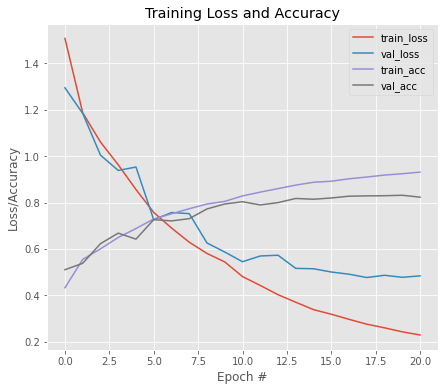


Model Performance Summary:

Min validation loss: 0.4765145480632782  at EPOCH: 18

Validation Accuracy:  0.8285416960716248
Model: "Base_learner_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 30752)             0         
_________________________________________________________________
dense_55 (Dense)             (None, 512)               15745536  
_________________________________________________________________
dense_56 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_57 (Dense)             (None, 9)                 2313

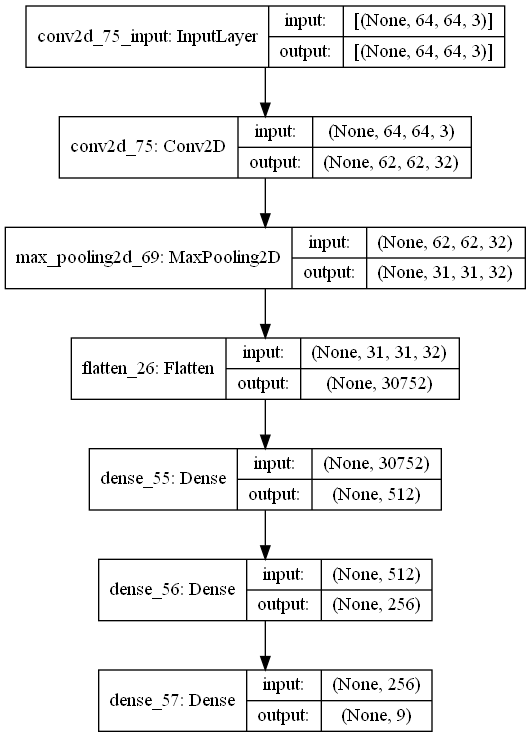

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 9ms/step - loss: 1.8629 - accuracy: 0.3016 - val_loss: 1.5767 - val_accuracy: 0.4008

Epoch 00001: val_loss improved from inf to 1.57673, saving model to Base_learner_6.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 9ms/step - loss: 1.5026 - accuracy: 0.4360 - val_loss: 1.5374 - val_accuracy: 0.3927

Epoch 00002: val_loss improved from 1.57673 to 1.53740, saving model to Base_learner_6.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 9ms/step - loss: 1.3331 - accuracy: 0.5165 - val_loss: 1.1395 - val_accuracy: 0.5923

Epoch 00003: val_loss improved from 1.53740 to 1.13949, saving model to Base_learner_6.hdf5
Epoch 4/40

Epoch 00004: LearningRateScheduler 

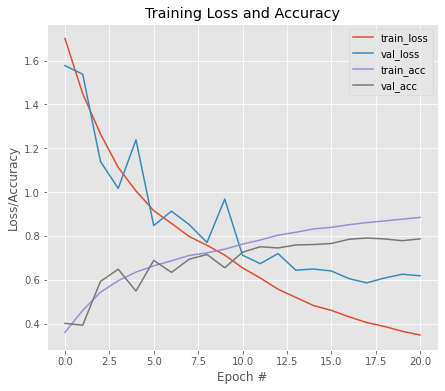


Model Performance Summary:

Min validation loss: 0.5858704447746277  at EPOCH: 18

Validation Accuracy:  0.7904166579246521
Model: "Base_learner_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 32, 32, 512)       147968    
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 16, 16, 512)       0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_58 (Dense)             (None, 512)               6710

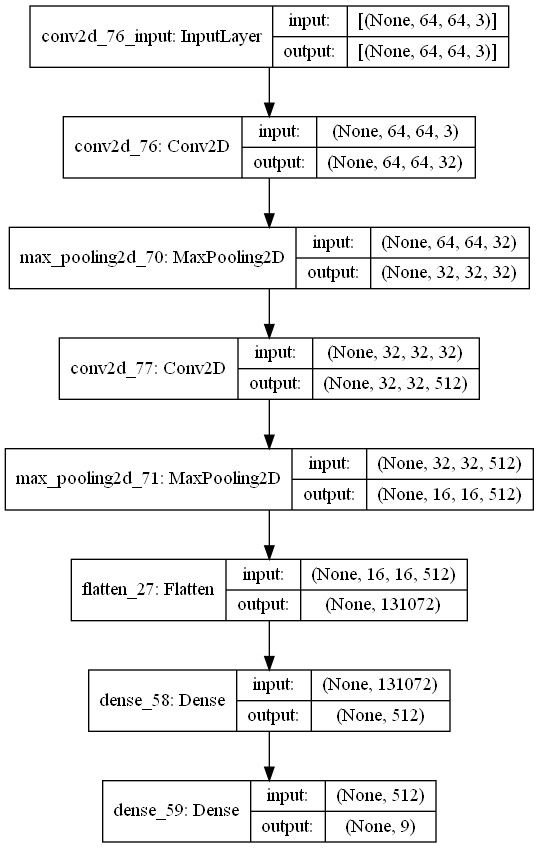

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 24s 39ms/step - loss: 1.6417 - accuracy: 0.4120 - val_loss: 1.4218 - val_accuracy: 0.5031

Epoch 00001: val_loss improved from inf to 1.42181, saving model to Base_learner_7.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 23s 38ms/step - loss: 1.1175 - accuracy: 0.6009 - val_loss: 1.0668 - val_accuracy: 0.5981

Epoch 00002: val_loss improved from 1.42181 to 1.06681, saving model to Base_learner_7.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 23s 38ms/step - loss: 0.9761 - accuracy: 0.6488 - val_loss: 0.9975 - val_accuracy: 0.6165

Epoch 00003: val_loss improved from 1.06681 to 0.99749, saving model to Base_learner_7.hdf5
Epoch 4/40

Epoch 00004: LearningRateSche

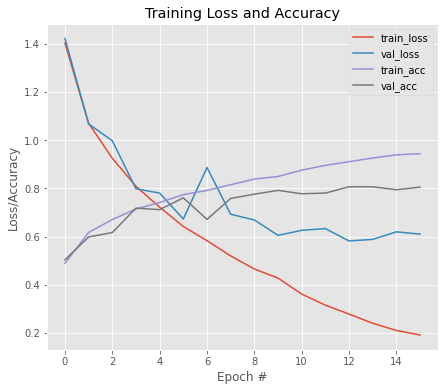


Model Performance Summary:

Min validation loss: 0.5815540552139282  at EPOCH: 13

Validation Accuracy:  0.8064583539962769
Model: "Base_learner_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_60 (Dense)             (None, 9)                 294921    
Total params: 295,817
Trainable params: 295,817
Non-trainable params: 0
_________________________________________________________________
None


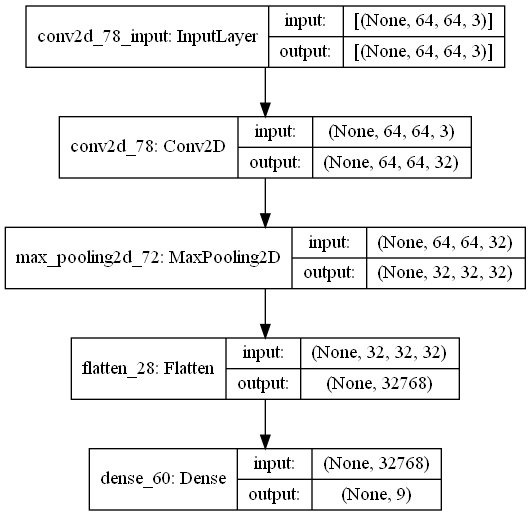

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 4s 6ms/step - loss: 1.8031 - accuracy: 0.3245 - val_loss: 1.4288 - val_accuracy: 0.4629

Epoch 00001: val_loss improved from inf to 1.42882, saving model to Base_learner_8.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.4363 - accuracy: 0.4702 - val_loss: 1.3769 - val_accuracy: 0.4627

Epoch 00002: val_loss improved from 1.42882 to 1.37691, saving model to Base_learner_8.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 3s 5ms/step - loss: 1.3756 - accuracy: 0.4930 - val_loss: 1.2719 - val_accuracy: 0.5394

Epoch 00003: val_loss improved from 1.37691 to 1.27191, saving model to Base_learner_8.hdf5
Epoch 4/40

Epoch 00004: LearningRateScheduler 

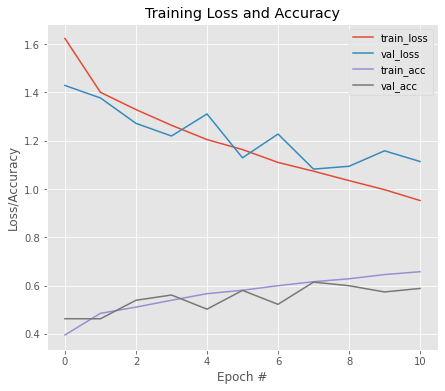


Model Performance Summary:

Min validation loss: 1.0824615955352783  at EPOCH: 8

Validation Accuracy:  0.6143749952316284
Model: "Base_learner_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 32, 32, 512)       147968    
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 16, 16, 512)       0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_61 (Dense)             (None, 9)                 11796

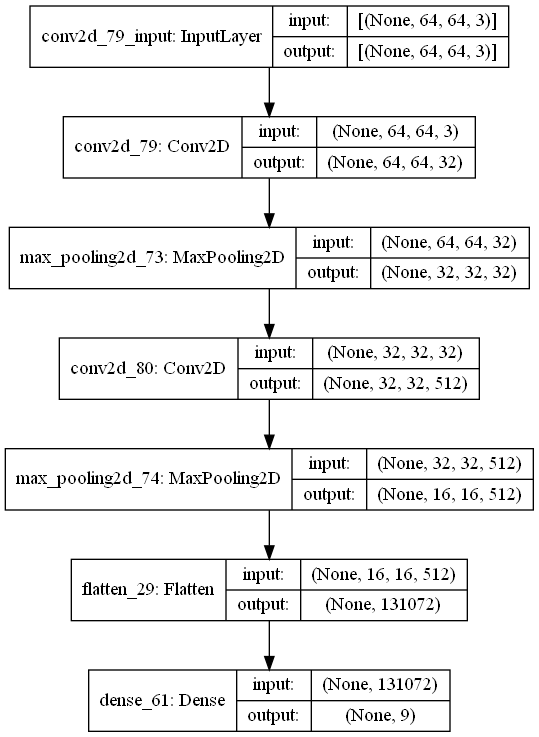

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 15s 24ms/step - loss: 1.7048 - accuracy: 0.3791 - val_loss: 1.2860 - val_accuracy: 0.5315

Epoch 00001: val_loss improved from inf to 1.28601, saving model to Base_learner_9.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 14s 24ms/step - loss: 1.2239 - accuracy: 0.5682 - val_loss: 1.1084 - val_accuracy: 0.5817

Epoch 00002: val_loss improved from 1.28601 to 1.10841, saving model to Base_learner_9.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 14s 24ms/step - loss: 1.0795 - accuracy: 0.6112 - val_loss: 0.9619 - val_accuracy: 0.6685

Epoch 00003: val_loss improved from 1.10841 to 0.96190, saving model to Base_learner_9.hdf5
Epoch 4/40

Epoch 00004: LearningRateSche

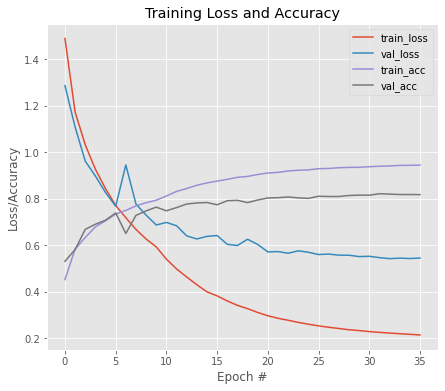


Model Performance Summary:

Min validation loss: 0.5428428649902344  at EPOCH: 33

Validation Accuracy:  0.8202083110809326


In [47]:
# Run the ensemble

build_dynamic_ensemble()

## ENSEMBLE PERFORMANCE SUMMARY

Base Learner Performnace Summmary:


,Model,Val Acc,Train Acc,Val Loss,Train Loss
0,Base_learner_0,0.801458,0.944687,0.600968,0.187363
1,Base_learner_1,0.760208,0.843021,0.710571,0.456177
2,Base_learner_2,0.779792,0.929167,0.701402,0.222059
3,Base_learner_3,0.636250,0.694167,1.034361,0.869407
4,Base_learner_4,0.732083,0.789844,0.788597,0.633834
5,Base_learner_5,0.828542,0.931146,0.476515,0.228728
6,Base_learner_6,0.790417,0.884375,0.585870,0.348038
7,Base_learner_7,0.806458,0.943542,0.581554,0.191407
8,Base_learner_8,0.614375,0.657552,1.082462,0.952360
9,Base_learner_9,0.820208,0.944531,0.542843,0.214982


,Model,Val Acc
0,Base_learner_0,0.801458
1,Base_learner_1,0.760208
2,Base_learner_2,0.779792
3,Base_learner_3,0.636250
4,Base_learner_4,0.732083
5,Base_learner_5,0.828542
6,Base_learner_6,0.790417
7,Base_learner_7,0.806458
8,Base_learner_8,0.614375
9,Base_learner_9,0.820208


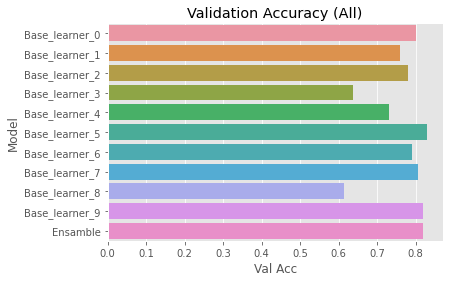

In [75]:
run_dynamic_ensamble()

In [102]:
!nvidia-smi

Fri Apr 30 10:53:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.33       Driver Version: 461.33       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro T2000 wi... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8     1W /  N/A |   3019MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [101]:
gc.collect()

89